### 展示专家推荐的服装搭配组合

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

#### 一、读取搭配组合，存储至字典

##### （一）原始数据展示

In [2]:
# 原始数据展示
root = '../Dataes/OriginDataes/dim_fashion_matchsets.txt'
data = pd.read_csv(root,sep=' ')
data.columns = ['index','item_set'] # 定义列名
data = data.drop('index',axis=1) # 删除index列名
data.head(5)

,item_set
0,1842610;2741506
1,"893028;993019,1375599,1913565,3036503;2849440;..."
2,2612866;1272124;2181942
3,3128145;2683359;855149
4,642818;2636382


##### （二）定义DataReader类，实现对原始数据的处理

|类型|名称|输入|输出|说明|
|--|--|--|--|--|
|变量|root|||专家推荐搭配组合所在的文件路径|
|变量|matches|||以dataframe格式保存的搭配信息|
|方法|__init__(self)|无|无|初始化函数，实现文件的读入，搭配信息的生成|
|方法|create_sets(self)|无|summary(dict)：处理后的搭配信息数据|将生成的搭配信息，根据搭配信息的格式再次处理，以字典形式保存|
|方法|acount_num(self,sets)|sets|count(int)|统计每个搭配类别中的容量大小|

##### （三）DataReader对象的操作流程

* 初始化对象，对象实例化时调用__init__()实现:读取专家搭配数据'dim_fashion_matchsets.txt',转换成dataframe格式，赋值于self.matchsets
* 数据处理，对象调用create_sets()实现:读取self.matchsets,通过分隔符';',切分相互组合搭配的服装集合,以列表的形式保存;通过分隔符',',切分同一集合下的可替换服装搭配，以列表的形式保存;返回summary,为字典格式；其中key为搭配索引号，范围为0~len(summary-1);values为列表形式的各搭配组合;
* 数据统计，对象调用acount_num()实现:读取每个搭配组合数据（字符串），根据分隔符统计每个大类（每个搭配）的具体容量，并返回，结果为列表形式，count[i]表示第i个搭配的各类服装的数量情况

* DataReader类的实现

In [3]:
class DataReader:
    # 初始化函数,读取文件dim_fashion_matchsets.txt文件
    def __init__(self):
        self.root = '../Dataes/OriginDataes/dim_fashion_matchsets.txt'
        matchsets = pd.read_csv(self.root,sep=' ')
        matchsets.columns = ['index','item_set'] # 定义列名
        self.matchsets = matchsets.drop('index',axis=1) # 删除index列名
    
    # 处理文件,根据self.matchsets生成对应组合，存储在字典中
    def create_summary(self):
        summary = {} #存储总的搭配组合
        for i in range(0,len(self.matchsets[:])):
            sets = self.matchsets['item_set'][i] # 原搭配信息
            big_cloths = sets.split(';') # 分割各大类
            count = self.acount_num(sets) #计算当前组合下各大类的数量
            # print(count)
            for j in range(0,len(count)):
                cloths = big_cloths[j].split(',')
                big_cloths[j] = cloths
            summary[i] = big_cloths
        return summary
    # 给定搭配组合（字符串），得到各大类的数量，以列表的形式返回
    def acount_num(self,sets):
        types = sets.split(';')
        count = []
        for type_cloths in types:
            num_cloth = type_cloths.split(',')
            count.append(len(num_cloth))
        return count  

* 获取处理后的搭配信息，赋值至sets（字典格式）

In [4]:
# 读取数据
data = DataReader()
# 数据处理
summary = data.create_summary()
# 获取第i个服装搭配组合，此处i为1
item_sets_1 = data.matchsets['item_set'].tolist()[1]
# 统计该服装搭配组合的各类服装数量情况
data.acount_num(item_sets_1)

[1, 4, 1, 1, 3, 3, 1]

* sumamry预览

In [5]:
for i in range(0,5):
    print(summary[i])

[['1842610'], ['2741506']]
[['893028'], ['993019', '1375599', '1913565', '3036503'], ['2849440'], ['2546147'], ['2329974', '2661094', '347849'], ['884801', '127779', '3122713'], ['2338561']]
[['2612866'], ['1272124'], ['2181942']]
[['3128145'], ['2683359'], ['855149']]
[['642818'], ['2636382']]


#### 二、根据搭配组合，生成图片并展示

##### （一）原始数据展示

In [6]:
contents = pd.read_csv('../Dataes/OriginDataes/dim_items.txt',sep=' ')
contents.columns = ['item_id','cat_id','None']
contents = contents.drop('None',axis = 1)
contents.head(10)

,item_id,cat_id
0,49,228
1,59,284
2,109,461
3,119,368
4,154,188
5,179,228
6,264,368
7,374,368
8,414,368
9,424,160


##### （二）定义PicReader类，实现对服装图像的处理

|类型|名称|输入|输出|备注|
|--|--|--|--|--|
|变量|contents|||所有服装及其对应的类别文件所在的文件路径|
|方法|__init__(self)|无|无|初始化函数，实现文件的读入|
|方法|read_cat(self)|无|contents(dataframe)：处理后的服装种类信息|将生成的搭配信息，drop掉一些列，并以字典形式保存|
|方法|complete_cat(self,sets,contents)|sets(dict),contents(dataframe)|sets_new|遍历sets，对每个item_id进行索引，在contents中查找对应的cat_id,并拼接|
|方法|present_pic(self,item_sets)|items_sets(list)|error_matches(list)|通过图片展示item_sets(当前服装搭配组合)的图像信息,返回未能成功存储的搭配组合error_matches
|方法|store_img(self,item_sets,name)|items_sets(list),name(str)|无|存储展示的item_sets(当前服装搭配组合)的图片搭配结果（.png）|

##### （三）PicReader对象的操作流程

* 初始化对象，对象实例化时调用__init__()实现:调用read_cat()实现，读取专家搭配数据'dim_items.txt',转换成dataframe格式，赋值于self.contents
* 数据处理，对象调用complete(sets,contents)实现:读取sets,contents;对sets中的item_id进行遍历，在contents中进行检索并获取对应的cat_id,将二者拼接，用于读取文件路径
* 搭配组合图像数据生成，对象调用present_pic(item_sets)实现:读取item_sets,获取该搭配组合对应的图像数据，并生成和展示搭配组合的图像
* 搭配组合图像数据保存，对象调用store_img(item_sets,name)实现:将生成的item_sets对应的搭配组合图像，存储在name对应的路径下

In [7]:
class PicReader:
    # 初始化函数，指定图片的读取路径
    def __init__(self):
        self.contents = self.read_cat('../Dataes/OriginDataes/dim_items.txt')
    
    # 定义函数实现查表，返回当前item_id的路径
    # 注意，应当使用OriginData/dim_items.txt实现对对应大类的cat_id的检索
    def read_cat(self,path):
        # path = '../Dataes/OriginDataes/dim_items.txt'
        contents = pd.read_csv(path,sep=' ')
        contents.columns = ['item_id','cat_id','None']
        contents = contents.drop('None',axis = 1)
        return contents
    
    # 定义函数实现对item_id对应的文件路径作索引
    def complete_cat(self,sets,contents):
        # 遍历sets中的元素，将编号更改为cat_id/item_id
        sets_new = {}
        for cat in sets.items():
            key = cat[0]
            item_id_sets = cat[1]

            sets_new[key] = []
            for i in range(0,len(item_id_sets)):
                sets_new[key].append([])
                for item_id in item_id_sets[i]:
                    # 在contents中索引item_id 对应的cat_id
                    try:
                        cat_id = str(contents[contents['item_id'] == int(item_id)]['cat_id'].values[0])
                    except:
                        cat_id='未知'
                        print('error')
                    item_id_new = cat_id+'/'+str(item_id)
                    sets_new[key][i].append(item_id_new)
        return sets_new
    
    # 根据存储的文件路径读取并展示,summary中存储的为路径信息
    def present_pic(self,sets):
        error_matchsets = []
        for i in list(sets.keys()):
            # print(summary_new[i])
            try:
                store_img(sets[i],'/root/cai/pics_matches/matchsets/match_'+str(i)+'.jpg')
            except:
                error_matchsets.append(sets[i])
                print('搭配组合%d生成失败' %(i))
        return error_matchsets
    
    
    # 定义函数实现对搭配组合的存储(图片形式)，输入为item_sets：列表格式的搭配组合；name：要保存的图片名
    def store_img(item_sets,name):
        # item_sets = sets_new[1]
        # 获取画布的长度和宽度(图片个数)
        height = max([len(item_set) for item_set in item_sets])
        weight = len(item_sets)
        # print('weight:%d,height:%d' %(weight,height))
        for i,item_set in enumerate(item_sets):
            for j,item in enumerate(item_set):
                img_path = '/root/cai/pics_classfied/' + item + '.jpg'
                index = j*weight+i+1
                try:
                    img = cv2.imread(img_path)
                    # img = cv2.imread('test1.png', 0)
                    # print('读取成功',img.shape)
                except:
                    #print('error')
                    img = cv2.imread('error.jpg')
                    #img = cv2.imread('test1.png', 0)
                    print('图片读取失败:%s' %img_path)
                # print(height,weight,index)
                b,g,r = cv2.split(img) # 将图像通道分离开
                img = cv2.merge([r,g,b]) # 重新以RGB形式组合
                plt.subplot(height,weight,index)
                plt.imshow(img)
                if index<=weight: # 在第一行的图片标题设置为大类名称
                    plt.title('cloth')
                plt.axis('off')
                plt.xticks()
                plt.yticks()
        plt.savefig(name) 
                # print('height:%d,weight:%d,index:%d'%(height,weight,j*weight+i+1))

In [8]:
# 定义函数实现对搭配组合的存储(图片形式)，输入为item_sets：列表格式的搭配组合；name：要保存的图片名
def store_img(item_sets,name):
    # item_sets = sets_new[1]
    # 获取画布的长度和宽度(图片个数)
    height = max([len(item_set) for item_set in item_sets])
    weight = len(item_sets)
    # print('weight:%d,height:%d' %(weight,height))
    for i,item_set in enumerate(item_sets):
        for j,item in enumerate(item_set):
            img_path = '/root/cai/pics_classfied/' + item + '.jpg'
            index = j*weight+i+1
            try:
                img = cv2.imread(img_path)
                # img = cv2.imread('test1.png', 0)
                # print('读取成功',img.shape)
            except:
                #print('error')
                img = cv2.imread('error.jpg')
                #img = cv2.imread('test1.png', 0)
                print('图片读取失败:%s' %img_path)
            # print(height,weight,index)
            b,g,r = cv2.split(img) # 将图像通道分离开
            img = cv2.merge([r,g,b]) # 重新以RGB形式组合
            
            plt.subplot(height,weight,index)
            plt.imshow(img)
            if index<=weight: # 在第一行的图片标题设置为大类名称
                plt.title('cloth')
            plt.axis('off')
            plt.xticks()
            plt.yticks()
    plt.savefig(name) 
            # print('height:%d,weight:%d,index:%d'%(height,weight,j*weight+i+1))

In [10]:
pic = PicReader()
contents = pic.read_cat('../Dataes/OriginDataes/dim_items.txt')
summary_new = pic.complete_cat(summary,contents)

搭配组合1生成失败


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


搭配组合622生成失败
搭配组合623生成失败
搭配组合775生成失败
搭配组合815生成失败
搭配组合844生成失败
搭配组合1041生成失败
搭配组合1090生成失败
搭配组合1137生成失败
搭配组合1424生成失败
搭配组合1583生成失败
搭配组合1850生成失败
搭配组合1971生成失败
搭配组合2126生成失败
搭配组合2244生成失败
搭配组合2491生成失败
搭配组合2566生成失败
搭配组合2577生成失败
搭配组合2718生成失败
搭配组合2770生成失败
搭配组合3052生成失败
搭配组合3248生成失败
搭配组合3427生成失败
搭配组合3439生成失败
搭配组合3462生成失败
搭配组合3478生成失败
搭配组合3720生成失败
搭配组合3836生成失败
搭配组合4149生成失败
搭配组合4399生成失败
搭配组合4649生成失败
搭配组合4659生成失败
搭配组合4663生成失败
搭配组合4776生成失败
搭配组合4890生成失败
搭配组合4975生成失败
搭配组合5274生成失败
搭配组合5277生成失败
搭配组合5359生成失败
搭配组合5689生成失败
搭配组合6024生成失败
搭配组合6141生成失败
搭配组合6350生成失败
搭配组合6569生成失败
搭配组合6888生成失败
搭配组合7193生成失败
搭配组合7465生成失败
搭配组合7552生成失败
搭配组合7877生成失败
搭配组合8157生成失败
搭配组合8220生成失败
搭配组合8352生成失败
搭配组合8862生成失败
搭配组合9323生成失败
搭配组合9566生成失败
搭配组合9769生成失败
搭配组合9774生成失败
搭配组合9980生成失败
搭配组合10320生成失败
搭配组合10361生成失败
搭配组合10482生成失败
搭配组合10652生成失败
搭配组合10691生成失败
搭配组合10748生成失败
搭配组合10829生成失败
搭配组合10868生成失败
搭配组合10975生成失败
搭配组合11055生成失败
搭配组合11172生成失败
搭配组合11206生成失败
搭配组合11386生成失败
搭配组合11571生成失败
搭配组合11610生成失败
搭配组合11627生成失败
搭配组合12213生成失败
搭配组合12777生成失败
搭配组合12806生成失

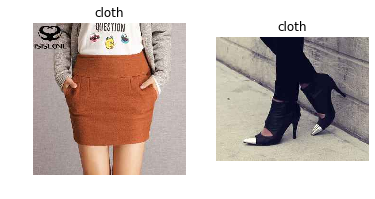

In [11]:
error_sets = pic.present_pic(summary_new)

In [12]:
len(error_sets)

144

In [13]:
len(summary_new)

23104